In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from scipy import stats

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,6)

Using TensorFlow backend.


In [2]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', keras.__version__)

# Same labels will be reused throughout the program
LABELS = ['Downstairs','Jogging','Sitting','Standing','Upstairs','Walking']

keras version  2.2.2


In [3]:
def show_basic_dataframe_info(dataframe):

    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

    
def read_data(file_path):

    column_names = ['user-id','activity','timestamp','x-axis','y-axis','z-axis']
    df = pd.read_csv(file_path,header=None,names=column_names)
    
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,inplace=True,to_replace=r';',value=r'')
    
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

In [4]:
# Load data set containing all the data from csv
df = read_data('../../data//WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt')

In [5]:
show_basic_dataframe_info(df)
df.head(10)

Number of columns in the dataframe: 6
Number of rows in the dataframe: 1098203



,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.7,12.7,0.5
1,33,Jogging,49106062271000,5.0,11.3,1.0
2,33,Jogging,49106112167000,4.9,10.9,-0.1
3,33,Jogging,49106222305000,-0.6,18.5,3.0
4,33,Jogging,49106332290000,-1.2,12.1,7.2
5,33,Jogging,49106442306000,1.4,-2.5,-6.5
6,33,Jogging,49106542312000,-0.6,10.6,5.7
7,33,Jogging,49106652389000,-0.5,13.9,7.1
8,33,Jogging,49106762313000,-8.4,11.4,5.1
9,33,Jogging,49106872299000,1.0,1.4,1.6


           activity                                          
activity Downstairs Jogging Sitting Standing Upstairs Walking
user-id                                                      
1            2941.0 11056.0     nan      nan   3120.0 12861.0
2               nan 11786.0     nan      nan      nan 11739.0
3            3326.0 11018.0  1609.0   2824.0   3411.0 12973.0
4            1763.0   895.0  1257.0      nan   1377.0  6079.0
5            3281.0  6405.0  1664.0   1515.0   3387.0 12257.0
6            1433.0 11818.0  1679.0    709.0   1666.0 12399.0
7            2257.0  9183.0  2529.0   2364.0   3601.0 11033.0
8            3346.0 10313.0  2699.0   3269.0   4453.0 17108.0
9               nan     nan     nan      nan      nan 12923.0
10           3795.0 12084.0     nan   1660.0   4296.0 13048.0
11           2674.0 12454.0     nan      nan   4392.0 12138.0
12           2870.0 12360.0  2289.0   1670.0   2654.0 10798.0
13           4241.0 12329.0  1179.0   1659.0   4638.0 13047.0
14      

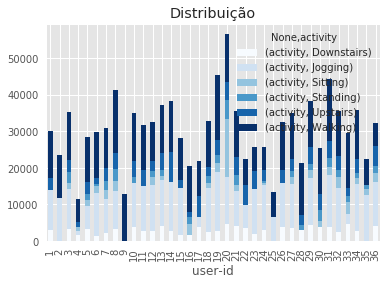

In [6]:
activity_of_subjects = pd.DataFrame(df.groupby("user-id")["activity"].value_counts())
print(activity_of_subjects.unstack())
activity_of_subjects.unstack().plot(kind='bar', stacked=True, colormap='Blues', title="Distribuição")
plt.show()

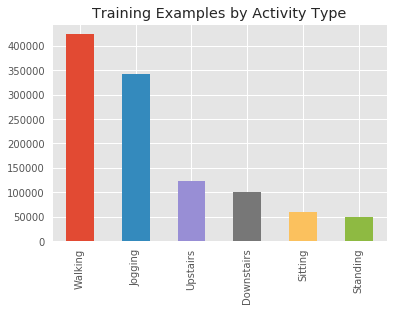

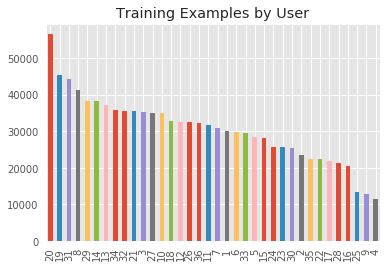

In [7]:
# Show how many training examples exist for each of the six activities
df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()
# Better understand how the recordings are spread across the different
# users who participated in the study
df['user-id'].value_counts().plot(kind='bar',
                                  title='Training Examples by User')
plt.show()

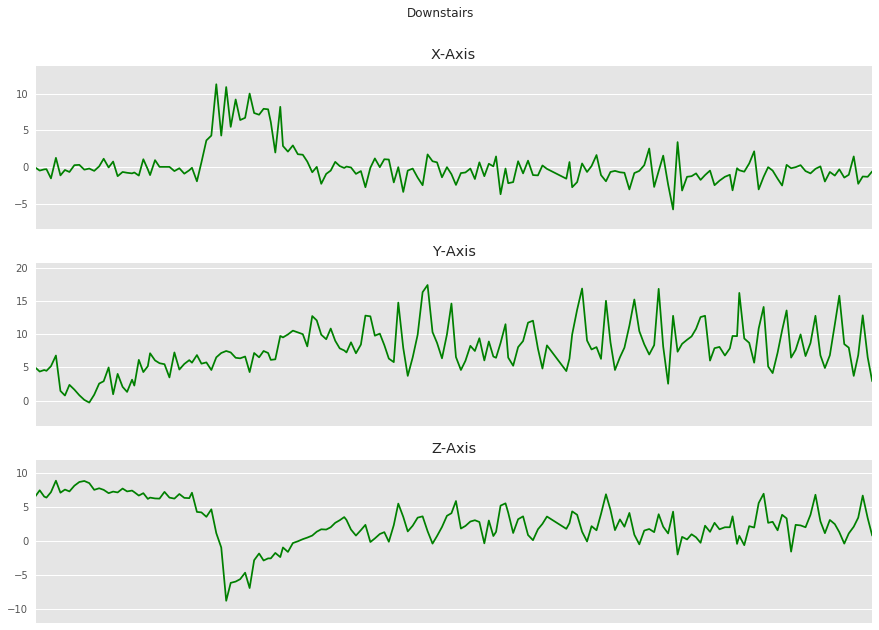

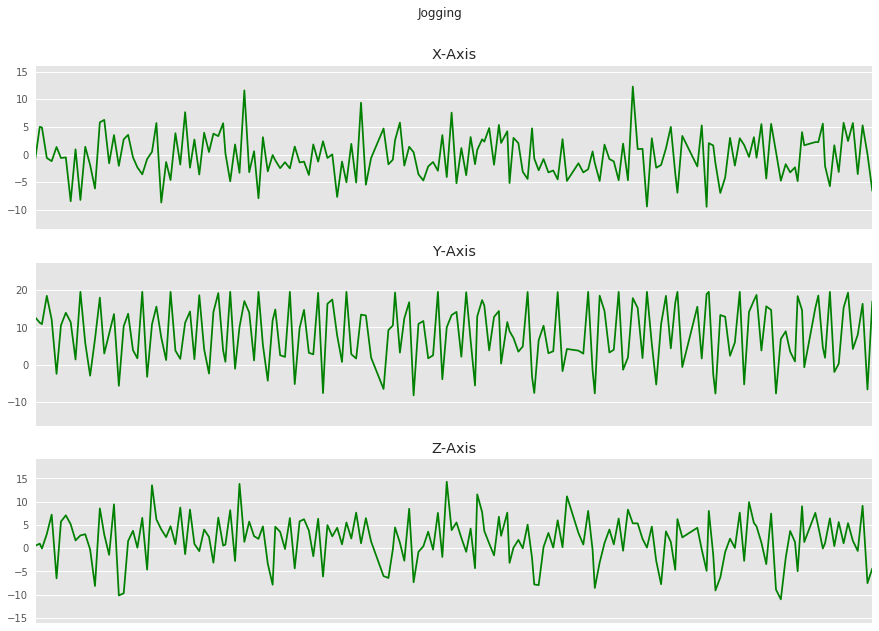

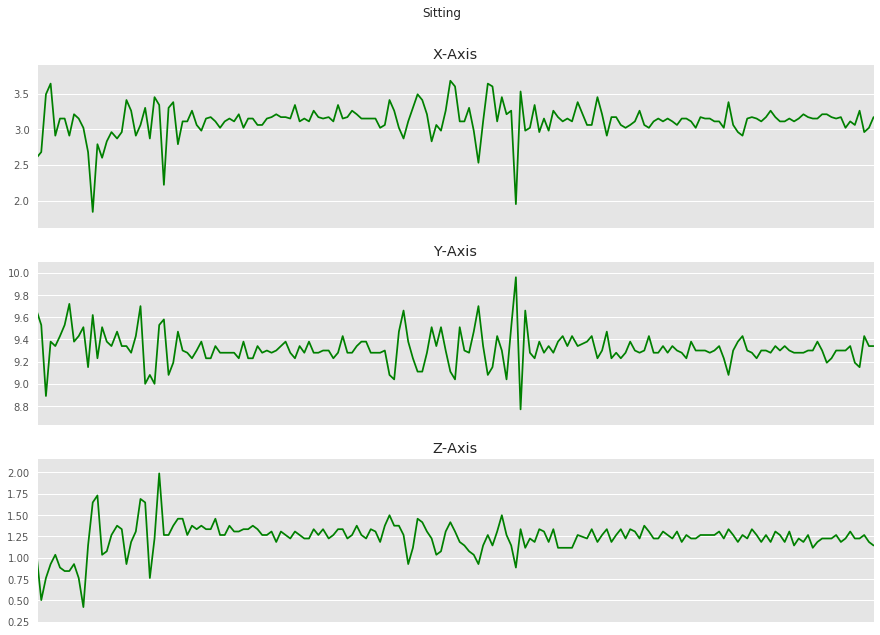

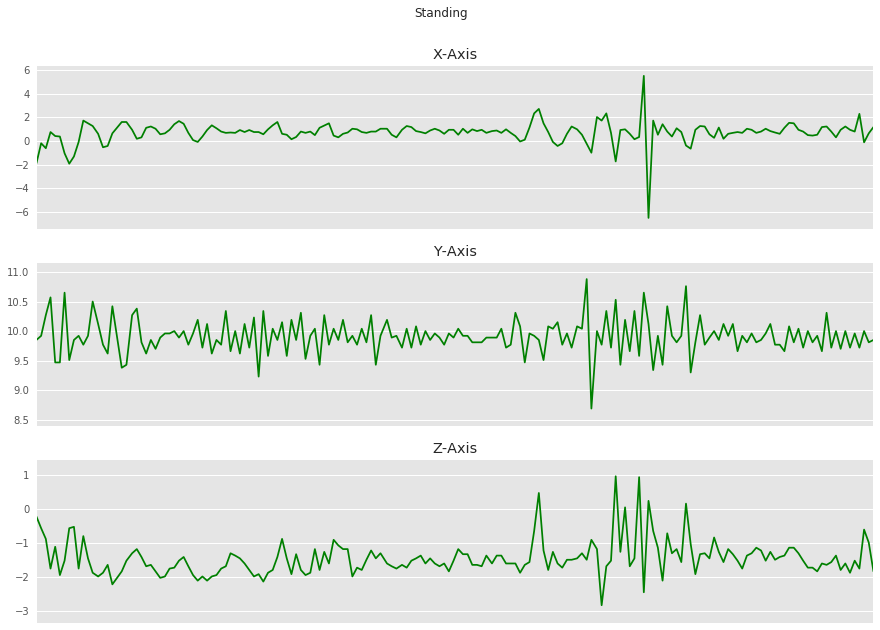

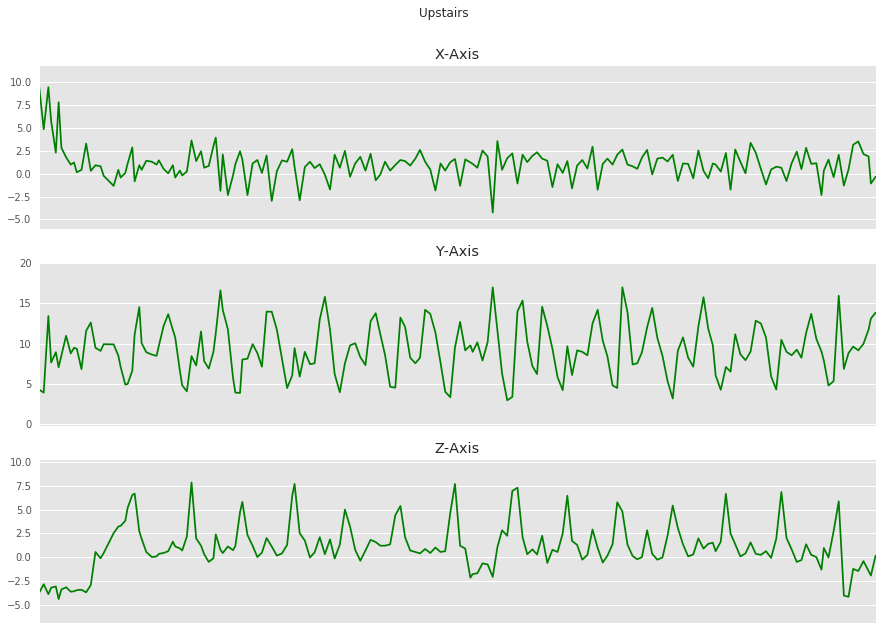

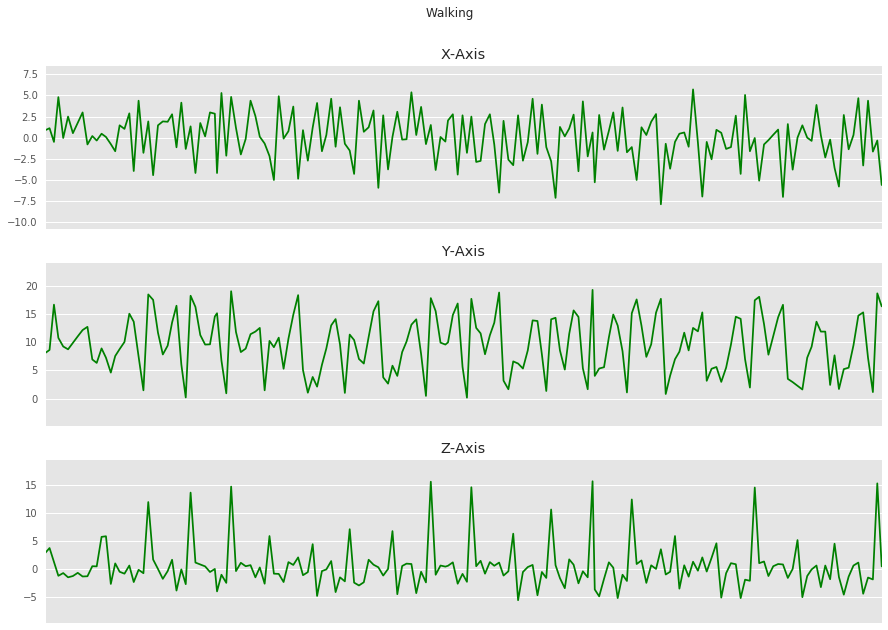

In [8]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:180]
    plot_activity(activity, subset)

In [9]:
# Define column name of the label vector
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

In [10]:
# Differentiate between test set and training set
df_test = df[df['user-id'] > 28]
df_train = df[df['user-id'] <= 28]

In [11]:
pd.options.mode.chained_assignment = None  # default='warn'
df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()
# Round numbers
df_train = df_train.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

In [12]:
def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

# The number of steps within one time segment
TIME_PERIODS = 80

# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 40

x_train, y_train = create_segments_and_labels(df_train,TIME_PERIODS,STEP_DISTANCE,LABEL)
x_test, y_test = create_segments_and_labels(df_test,TIME_PERIODS,STEP_DISTANCE,LABEL)

In [13]:
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

x_train shape:  (20868, 80, 3)
20868 training samples
y_train shape:  (20868,)


In [14]:
# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [15]:
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)

x_train shape: (20868, 240)
input_shape: 240


In [16]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

In [17]:
y_train_hot = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train_hot.shape)

New y_train shape:  (20868, 6)


In [18]:
x_train.shape[1:]

(240,)

In [19]:
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, 3), input_shape=(input_shape,)))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Flatten())
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 80, 100)           400       
_________________________________________________________________
dense_2 (Dense)              (None, 80, 100)           10100     
_________________________________________________________________
dense_3 (Dense)              (None, 80, 100)           10100     
_________________________________________________________________
flatten_1 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 48006     
Total params: 68,606
Trainable params: 68,606
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='dnn_best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_m.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,y_train_hot,batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=callbacks_list,validation_split=0.2,verbose=1)

Train on 16694 samples, validate on 4174 samples
Epoch 1/50
16694/16694 [==============================] - 2s 96us/step - loss: 1.0659 - acc: 0.6467 - val_loss: 0.7118 - val_acc: 0.8141
Epoch 2/50
16694/16694 [==============================] - 1s 52us/step - loss: 0.5954 - acc: 0.7863 - val_loss: 0.6391 - val_acc: 0.8105
Epoch 3/50
16694/16694 [==============================] - 1s 52us/step - loss: 0.5237 - acc: 0.8063 - val_loss: 0.6376 - val_acc: 0.8261
Epoch 4/50
16694/16694 [==============================] - 1s 52us/step - loss: 0.4958 - acc: 0.8177 - val_loss: 0.6577 - val_acc: 0.7997
Epoch 5/50
16694/16694 [==============================] - 1s 52us/step - loss: 0.4691 - acc: 0.8290 - val_loss: 0.6352 - val_acc: 0.8189
Epoch 6/50
16694/16694 [==============================] - 1s 52us/step - loss: 0.4509 - acc: 0.8363 - val_loss: 0.6401 - val_acc: 0.7964
Epoch 7/50
16694/16694 [==============================] - 1s 52us/step - loss: 0.4244 - acc: 0.8472 - val_loss: 0.7233 - val_acc:

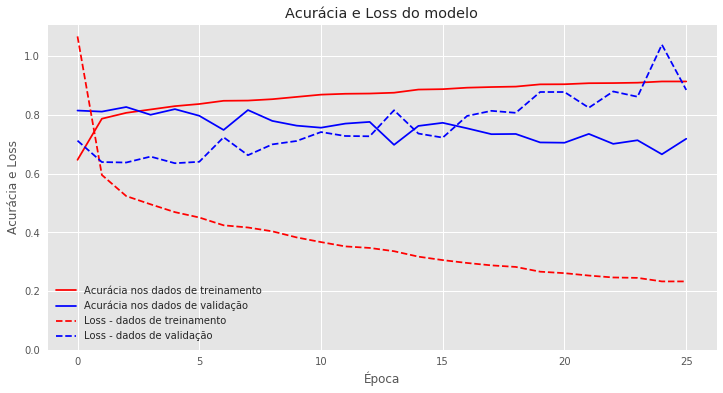

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['acc'], 'r', label='Acurácia nos dados de treinamento')
plt.plot(history.history['val_acc'], 'b', label='Acurácia nos dados de validação')
plt.plot(history.history['loss'], 'r--', label='Loss - dados de treinamento')
plt.plot(history.history['val_loss'], 'b--', label='Loss - dados de validação')
plt.title('Acurácia e Loss do modelo')
plt.ylabel('Acurácia e Loss')
plt.xlabel('Época')
plt.ylim(0)
plt.legend()
plt.show()

In [26]:
# Print confusion matrix for training data
y_pred_train = model_m.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))

score = model_m.evaluate(x_train, y_train_hot, verbose=1)

print('\nAccuracy on train data: %0.2f' % score[1])
print('\nLoss on test data: %0.2f' % score[0])

             precision    recall  f1-score   support

        0.0       0.63      0.58      0.60      1864
        1.0       0.98      0.98      0.98      6567
        2.0       0.99      0.99      0.99      1050
        3.0       0.99      0.99      0.99       833
        4.0       0.66      0.65      0.66      2342
        5.0       0.88      0.91      0.90      8212

avg / total       0.88      0.88      0.88     20868

20868/20868 [==============================] - 1s 43us/step

Accuracy on train data: 0.88

Loss on test data: 0.35


In [27]:
# Normalize features for testing data set
df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()

df_test = df_test.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

# Set input_shape / reshape for Keras
x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

y_test = np_utils.to_categorical(y_test, num_classes)

score = model_m.evaluate(x_test, y_test, verbose=1)

print('\nAccuracy on test data: %0.2f' % score[1])
print('\nLoss on test data: %0.2f' % score[0])

6584/6584 [==============================] - 0s 42us/step

Accuracy on test data: 0.76

Loss on test data: 1.37


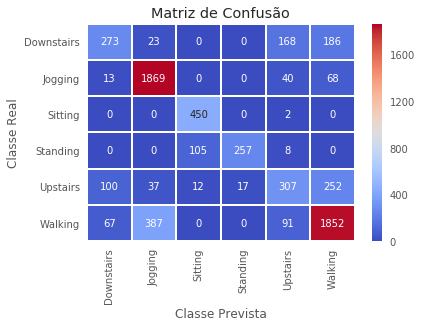

             precision    recall  f1-score   support

          0       0.60      0.42      0.50       650
          1       0.81      0.94      0.87      1990
          2       0.79      1.00      0.88       452
          3       0.94      0.69      0.80       370
          4       0.50      0.42      0.46       725
          5       0.79      0.77      0.78      2397

avg / total       0.75      0.76      0.75      6584



In [24]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Matriz de Confusão')
    plt.ylabel('Classe Real')
    plt.xlabel('Classe Prevista')
    plt.show()

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))